In [ ]:
# Imports

In [1]:
%pylab inline
%matplotlib inline
from matplotlib import pyplot as plt

from pyspark.mllib.regression import LabeledPoint
import numpy as np
from pyspark.ml import Pipeline
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml.linalg import Vectors
from pyspark.mllib.tree import DecisionTree, DecisionTreeModel
from pyspark.mllib.tree import GradientBoostedTrees, GradientBoostedTreesModel
from pyspark.mllib.regression import LabeledPoint, LinearRegressionWithSGD, LinearRegressionModel
from pyspark.ml.regression import LinearRegression

Populating the interactive namespace from numpy and matplotlib


In [2]:
# Load the data into Resilient Distributed Datasets (RDD)

In [3]:
path = "/regression-models/bike-dataset-hour-no-header.csv"
raw_data = sc.textFile(path)
num_data = raw_data.count()
records = raw_data.map(lambda x: x.split(","))
first = records.first()
print('First record: ', first)
print('Total number of records: ', num_data)


First record:  ['1', '2011-01-01', '1', '0', '1', '0', '0', '6', '0', '1', '0.24', '0.2879', '0.81', '0', '3', '13', '16']
Total number of records:  17379


In [ ]:
# Cache the results

In [4]:
records.cache()

PythonRDD[4] at RDD at PythonRDD.scala:48

In [5]:
# extract each categorical feature into a binary vector form, 
# we will need to know the feature mapping of each feature value to the index of the nonzero value 
# in our binary vector

In [6]:
def get_mapping(rdd, idx):
    print('index:', idx)
    return rdd.map(lambda fields: fields[idx]).distinct().zipWithIndex().collectAsMap()

In [7]:
# We have two categorical features
# 1. genres, is at index : 0
# 2. release_year is at index :  1

In [ ]:
print("Mapping of first categorical feasture column: %s" % get_mapping(records, 2))

In [ ]:
# Apply Mapping function to each categorical column

In [9]:
mappings = [get_mapping(records, i) for i in range(2,10)]

cat_len = sum([len(b) for b in mappings])
num_len = len(records.first()[11:15])
total_len = num_len + cat_len

index: 2
index: 3
index: 4
index: 5
index: 6
index: 7
index: 8
index: 9


In [ ]:
# We now have the mappings for each variable, 
# and we can see how many values in total we need for our binary vector representation:

In [10]:
print("Feature vector length for categorical features: %d" % cat_len)
print("Feature vector length for numerical features: %d" % num_len)
print("Total feature vector length: %d" % total_len)

Feature vector length for categorical features: 57
Feature vector length for numerical features: 4
Total feature vector length: 61


In [ ]:
# The next step is to use our extracted mappings to convert the categorical features to binary-encoded features.

In [21]:
def extract_features(record):
    cat_vec = np.zeros(cat_len)
    i = 0
    step = 0
    for field in record[2:9]: # catogorical feature
        print('extract_features', i)
        m = mappings[i]
        idx = m[field]
        cat_vec[idx + step] = 1
        i = i + 1
        step = step + len(m)
    num_vec = np.array([float(field) for field in record[10:14]])
    return np.concatenate((cat_vec, num_vec))



In [22]:
# The extract_label function simply converts the last column variable (Revenue) into a float

In [23]:
def extract_label(record):
    return float(record[-1])

In [24]:
#### 2.1 Decision Tree #######

In [25]:
# decision tree models typically work on raw features

In [26]:
def extract_features_dt(record):
    return np.array(map(float, record[2:14]))

In [27]:
# Extract the Data so that we are ready for training and prediction on Decision Tree model

In [28]:
data_dt = records.map(lambda r: LabeledPoint(extract_label(r), extract_features(r)))

In [29]:
# Show the Label and Feature Vector from the Dataset 
# 2.1.1 Decision Tree Categorical features

In [30]:
first_point_dt = data_dt.first()
print("Decision Tree Label: " + str(first_point_dt.label))
print("Decision Tree feature vector: " + str(first_point_dt.features))
print("Decision Tree feature vector length: " + str(len(first_point_dt.features)))

Decision Tree Label: 16.0
Decision Tree feature vector: [1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.24,0.2879,0.81,0.0]
Decision Tree feature vector length: 61


In [31]:
# Split the data into training and test sets (30% held out for testing)

In [32]:
(trainingData_dt, testData_dt) = data_dt.randomSplit([0.7, 0.3])

In [33]:
# Train a DecisionTree model.
#  Empty categoricalFeaturesInfo indicates all features are continuous.

In [34]:
model_dt = DecisionTree.trainRegressor(trainingData_dt, categoricalFeaturesInfo={},
                                    impurity='variance', maxDepth=5, maxBins=3000)

# Evaluate model on test instances and compute test error
predictions_dt = model_dt.predict(testData_dt.map(lambda x: x.features))
labelsAndPredictions_dt = testData_dt.map(lambda lp: lp.label).zip(predictions_dt)

In [35]:
# dt_model = DecisionTree.trainRegressor(data_dt,{})
# preds = dt_model.predict(data_dt.map(lambda p: p.features))
# actual = data.map(lambda p: p.label)
# true_vs_predicted_dt = actual.zip(preds)

In [36]:
print('Learned regression tree model:')
print(model_dt.toDebugString())


Learned regression tree model:
DecisionTreeModel regressor of depth 5 with 63 nodes
  If (feature 58 <= 0.5985)
   If (feature 21 <= 0.5)
    If (feature 27 <= 0.5)
     If (feature 40 <= 0.5)
      If (feature 57 <= 0.33)
       Predict: 74.63076923076923
      Else (feature 57 > 0.33)
       Predict: 141.18486882245273
     Else (feature 40 > 0.5)
      If (feature 57 <= 0.39)
       Predict: 226.46762589928056
      Else (feature 57 > 0.39)
       Predict: 432.37426900584796
    Else (feature 27 > 0.5)
     If (feature 57 <= 0.51)
      If (feature 0 <= 0.5)
       Predict: 395.5
      Else (feature 0 > 0.5)
       Predict: 227.72072072072072
     Else (feature 57 > 0.51)
      If (feature 4 <= 0.5)
       Predict: 651.0731707317074
      Else (feature 4 > 0.5)
       Predict: 393.21875
   Else (feature 21 > 0.5)
    If (feature 52 <= 0.5)
     If (feature 57 <= 0.41000000000000003)
      If (feature 50 <= 0.5)
       Predict: 60.656716417910445
      Else (feature 50 > 0.5)
       

In [37]:
# Root Suarred Error
def squared_log_error(pred, actual):
    return (np.log(pred + 1) - np.log(actual + 1))**2

# Aboslute Error
def abs_error(actual, pred):
     return np.abs(pred - actual)
# Mean Squared Error     
def squared_error(actual, pred):
    return (pred - actual)**2

In [38]:
# 2.1.2) Decision Tree Log

In [39]:
# testMSE_dt = labelsAndPredictions_dt.map(lambda lp: (lp[0] - lp[1]) * (lp[0] - lp[1])).sum() / float(testData.count())

rmsle_dt = np.sqrt(labelsAndPredictions_dt.map(lambda lp: squared_log_error(lp[0], lp[1])).mean())
mse = labelsAndPredictions_dt.map(lambda lp: squared_error(lp[0], lp[1])).mean()
mae = labelsAndPredictions_dt.map(lambda lp: abs_error(lp[0], lp[1])).mean()


In [40]:
print("Decision Tree Model - Root Mean Squared Log Error: %2.4f" % rmsle_dt)
print("Decision Tree Model - Mean Squared Error: %2.4f" % mse)
print("Decision Tree Model - Mean Absolute Error: %2.4f" % mae)

Decision Tree Model - Root Mean Squared Log Error: 1.3300
Decision Tree Model - Mean Squared Error: 16794.6977
Decision Tree Model - Mean Absolute Error: 99.7752


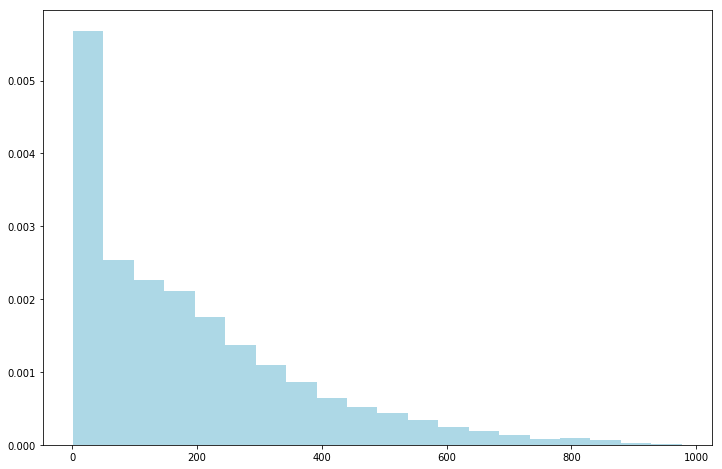

In [41]:
targets = records.map(lambda r: float(r[-1])).collect()
hist(targets, bins=20, color='lightblue', normed=True)
fig = matplotlib.pyplot.gcf()
fig.set_size_inches(12, 8)

In [42]:
# 2.1.3) Decision Tree Max Bins
# 2.14) Decision Tree Max Depth

In [43]:
# (RMSLE vs MaxDepth) and (RMSLE vs MaxBins) evaluation metric

In [44]:
def evaluate_dt(trainData, testData, maxDepthValue, maxBinsValue):
    modelDT = DecisionTree.trainRegressor(trainData, categoricalFeaturesInfo={},
                                    impurity='variance', maxDepth=maxDepthValue, maxBins=maxBinsValue)

    # Evaluate model on test instances and compute test error
    predits = modelDT.predict(testData.map(lambda x: x.features))
    labelsAndPredicts = testData.map(lambda lp: lp.label).zip(predits)
    rmsleDT = np.sqrt(labelsAndPredicts.map(lambda lp: squared_log_error(lp[0], lp[1])).mean())
    return rmsleDT

In [45]:
# 2.1.3) Decision Tree Max Bins

In [46]:
constantMaxDepthAndBinsParams = [32, 64, 80, 100, 200, 400]

metrics = [evaluate_dt(trainingData_dt, testData_dt, 5, param) # constant Max Depth
           for param in constantMaxDepthAndBinsParams]
print(constantMaxDepthAndBinsParams)
print(metrics)

[32, 64, 80, 100, 200, 400]
[1.3299982650284696, 1.3299736084463309, 1.3299736084463309, 1.3299736084463309, 1.3299736084463309, 1.3299736084463309]


Text(0,0.5,'RMSLE')

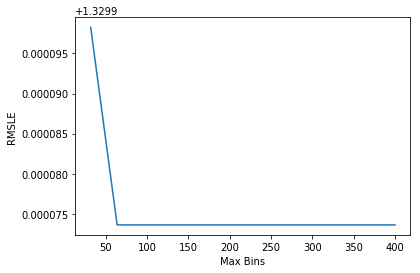

In [47]:
# Plotting : Decision Tree Max Bins
plot(constantMaxDepthAndBinsParams, metrics)
plt.xlabel('Max Bins')
plt.ylabel('RMSLE')

In [48]:
# 2.1.4) Decision Tree Max Depth

In [49]:
maxDepthAndConstantBinsParams = [3, 4, 5, 6, 7, 8]

metricsMaxDepth = [evaluate_dt(trainingData_dt, testData_dt, param, 150) 
           for param in maxDepthAndConstantBinsParams]
print(maxDepthAndConstantBinsParams)
print(metricsMaxDepth)

[3, 4, 5, 6, 7, 8]
[1.4172667298367021, 1.384561221341662, 1.3299736084463309, 1.281410054145026, 1.2386993024618247, 1.188596795315976]


Text(0,0.5,'RMSLE')

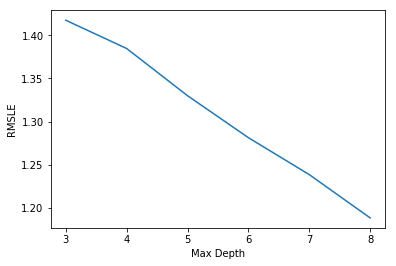

In [50]:
# Plotting : Decision Tree Max Depth
plot(maxDepthAndConstantBinsParams, metricsMaxDepth)
plt.xlabel('Max Depth')
plt.ylabel('RMSLE')

In [51]:
# 2.2. Gradient boost tree 

In [52]:
# Train a GradientBoostedTrees model.
#  Notes: (a) Empty categoricalFeaturesInfo indicates all features are continuous.
#         (b) Use more iterations in practice.

model_GBT = GradientBoostedTrees.trainRegressor(trainingData_dt,
                                            categoricalFeaturesInfo={}, numIterations=3, maxDepth=5, maxBins=64)

predictions_GBT = model_GBT.predict(testData_dt.map(lambda x: x.features))
labelsAndPredictions_GBT = testData_dt.map(lambda lp: lp.label).zip(predictions_GBT)

print('Learned regression Gradient boosted tree lmodel:')
print(model_GBT.toDebugString())

rmsle_gbt = np.sqrt(labelsAndPredictions_GBT.map(lambda lp: squared_log_error(lp[0], lp[1])).mean())
mse_gbt = labelsAndPredictions_GBT.map(lambda lp: squared_error(lp[0], lp[1])).mean()
mae_gbt = labelsAndPredictions_GBT.map(lambda lp: abs_error(lp[0], lp[1])).mean()

print("GradientBoostedTrees Model - Root Mean Squared Log Error: %2.4f" % rmsle_gbt)
print("GradientBoostedTrees Model - Mean Squared Error: %2.4f" % mse_gbt)
print("GradientBoostedTrees Model - Mean Absolute Error: %2.4f" % mae_gbt)

Learned regression Gradient boosted tree lmodel:
TreeEnsembleModel regressor with 3 trees

  Tree 0:
    If (feature 58 <= 0.5985)
     If (feature 21 <= 0.5)
      If (feature 27 <= 0.5)
       If (feature 40 <= 0.5)
        If (feature 57 <= 0.33)
         Predict: 74.63076923076923
        Else (feature 57 > 0.33)
         Predict: 141.18486882245273
       Else (feature 40 > 0.5)
        If (feature 57 <= 0.39)
         Predict: 226.46762589928056
        Else (feature 57 > 0.39)
         Predict: 432.37426900584796
      Else (feature 27 > 0.5)
       If (feature 57 <= 0.51)
        If (feature 0 <= 0.5)
         Predict: 395.5
        Else (feature 0 > 0.5)
         Predict: 227.72072072072072
       Else (feature 57 > 0.51)
        If (feature 4 <= 0.5)
         Predict: 651.0731707317074
        Else (feature 4 > 0.5)
         Predict: 393.21875
     Else (feature 21 > 0.5)
      If (feature 52 <= 0.5)
       If (feature 57 <= 0.41000000000000003)
        If (feature 50 <= 0.5)

GradientBoostedTrees Model - Root Mean Squared Log Error: 1.2227
GradientBoostedTrees Model - Mean Squared Error: 14062.4351
GradientBoostedTrees Model - Mean Absolute Error: 90.1993


In [53]:
# 2.2.1) Gradient boost tree iterations

In [54]:
def evaluate_gbt(trainData, testData, numIterationsValue, maxDepthValue, maxBinsValue):
    model_GBT = GradientBoostedTrees.trainRegressor(trainData,
                                            categoricalFeaturesInfo={}, numIterations=numIterationsValue,
                                                    maxDepth=maxDepthValue, maxBins=maxBinsValue)

    predictions_GBT = model_GBT.predict(testData.map(lambda x: x.features))
    labelsAndPredictions_GBT = testData.map(lambda lp: lp.label).zip(predictions_GBT)
    rmsleGBT = np.sqrt(labelsAndPredictions_GBT.map(lambda lp: squared_log_error(lp[0], lp[1])).mean())
    return rmsleGBT

[2, 3, 4]
[1.2857819708692249, 1.2176695926314738, 1.1814034780570388]


Text(0,0.5,'RMSLE')

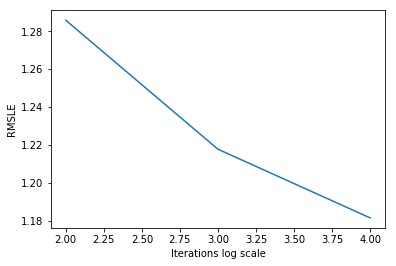

In [55]:
numInterationsParams = [2, 3, 4]

metrics_gbt_iterations = [evaluate_gbt(trainingData_dt, testData_dt, param, 5, 32)
           for param in numInterationsParams]
print(numInterationsParams)
print(metrics_gbt_iterations)

# Plotting
plot(numInterationsParams, metrics_gbt_iterations)
plt.xlabel('Iterations log scale')
plt.ylabel('RMSLE')

In [ ]:
# 2.2.2) Gradient boost tree Max Bins

[5, 10, 15]
[1.231483599093347, 1.2041713030682992, 1.2254782571630456]


Text(0,0.5,'RMSLE')

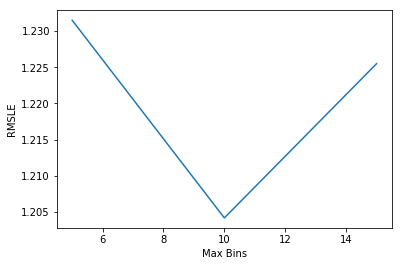

In [56]:
maxBinsParams = [5, 10, 15]

metrics_gbt_maxBins = [evaluate_gbt(trainingData_dt, testData_dt, 3, 5, param)
           for param in maxBinsParams]
print(maxBinsParams)
print(metrics_gbt_maxBins)

# Plotting : Decision Tree Max Depth
plot(maxBinsParams, metrics_gbt_maxBins)
plt.xlabel('Max Bins')
plt.ylabel('RMSLE')

In [57]:
# 2.2.3) Gradient boost tree Max Depth

[4, 5, 6]
[1.3088304792803007, 1.2176695926314738, 1.1527551333332848]


Text(0,0.5,'RMSLE')

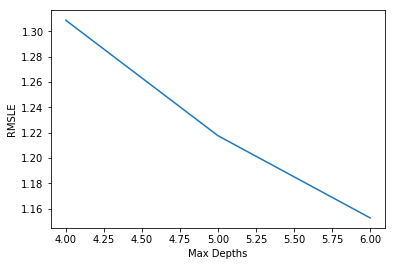

In [58]:
maxDepthParams = [4, 5, 6]

metrics_gbt_maxDepth = [evaluate_gbt(trainingData_dt, testData_dt, 3, param, 32)
           for param in maxDepthParams]
print(maxDepthParams)
print(metrics_gbt_maxDepth)

# Plotting
plot(maxDepthParams, metrics_gbt_maxDepth)
plt.xlabel('Max Depths')
plt.ylabel('RMSLE')

In [59]:
# 2.3. Linear regression model

In [60]:
# we can proceed with extracting feature vectors and labels from our data records

In [61]:
data_linear = records.map(lambda r: LabeledPoint(extract_label(r), extract_features(r)))

In [62]:
# Let's inspect the first record in the extracted feature RDD:

In [63]:
first_point = data_linear.first()
print("Label: " + str(first_point.label))
print("Linear Model feature vector:\n" + str(first_point.features))
print("Linear Model feature vector length: " + str(len(first_point.
features)))

Label: 16.0
Linear Model feature vector:
[1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.24,0.2879,0.81,0.0]
Linear Model feature vector length: 61


In [64]:
(trainingData_linear, testData_linear) = data_linear.randomSplit([0.7, 0.3])

In [16]:
model_LR = LinearRegressionWithSGD.train(trainingData_linear, iterations=5, step=0.01)
# Building a Regression Model with Spark
true_vs_predicted_LR = testData_linear.map(lambda p: (p.label, model_LR.predict(p.features)))
print("Linear Model predictions: " + str(true_vs_predicted_LR.take(5)))


predictions_linear = model_LR.predict(testData_linear.map(lambda x: x.features))
labelsAndPredictions_linear = testData_linear.map(lambda lp: lp.label).zip(predictions_linear)

Linear Model predictions: [(595380321.0, 8.7382057804175837e+72), (36869414.0, 1.2136396973989071e+72), (325771424.0, 3.8836470152728108e+72), (542351353.0, 7.6863847121795557e+72), (209035668.0, 1.5372769419272377e+73)]


In [ ]:
# 2.3.1) Linear regression Cross Validation

In [68]:
print('Training data size', trainingData_linear.count())
print('Test data size', testData_linear.count())

print('Total data size', trainingData_linear.count() + testData_linear.count())


Training data size 7562
Test data size 3304
Total data size 10866


In [70]:
def evaluate(train, test, iterations, step, regParam, regType, intercept):
    model = LinearRegressionWithSGD.train(train, iterations, step, 
                                          regParam=regParam, regType=regType, intercept=intercept)
    tp = test.map(lambda p: (p.label, model.predict(p.features)))
    rmsle = np.sqrt(tp.map(lambda lp: squared_log_error(lp[0], lp[1])).mean())
    return rmsle

[True, False]
[89.884748649928014, 89.884748534199261]


Text(0,0.5,'RMSLE')

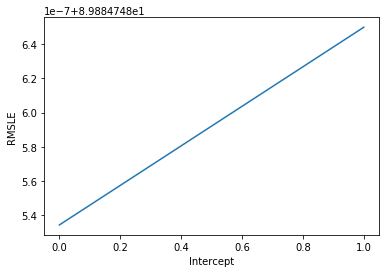

In [74]:
# 2.3.2.1) Intercept

params_intercept = [True, False]
metrics_intercept = [evaluate(trainingData_linear, testData_linear, 3, 0.01, 0.0, 'l2', param) for param in params_intercept]

print(params_intercept)
print(metrics_intercept)

# Plotting
plot(params_intercept, metrics_intercept)
plt.xlabel('Intercept')
plt.ylabel('RMSLE')

[1, 3, 6]
[31.282585328149491, 89.884748534199261, nan]


Text(0,0.5,'RMSLE')

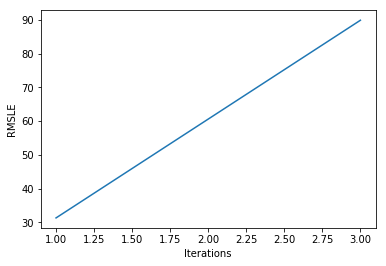

In [88]:
# 2.3.2.2) Iterations

params_iterations = [1, 3, 6]
metrics_iterations = [evaluate(trainingData_linear, testData_linear, param, 0.01, 0.0, 'l2', False) for param in params_iterations]

print(params_iterations)
print(metrics_iterations)

# Plotting
plot(params_iterations, metrics_iterations)
plt.xlabel('Iterations')
plt.ylabel('RMSLE')

[0.01, 0.025, 0.05, 0.1, 1.0]
[89.884748534199261, 92.622596281050932, 94.69412252509683, 96.765988312030728, 103.65075559271362]


Text(0,0.5,'RMSLE')

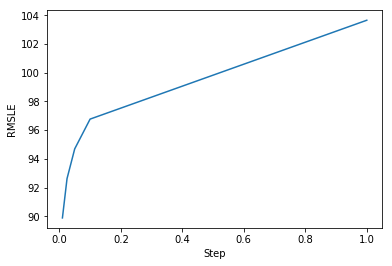

In [78]:
# 2.3.2.3) Step size

params_step = [0.01, 0.025, 0.05, 0.1, 1.0]
metrics_step = [evaluate(trainingData_linear, testData_linear, 3, param, 0.0, 'l2', False) for param in params_step]

print(params_step)
print(metrics_step)

# Plotting
plot(params_step, metrics_step)
plt.xlabel('Step')
plt.ylabel('RMSLE')

[0.0, 0.01, 0.1, 1.0, 10.0, 100.0]
[89.884748534199261, 89.884748534199261, 89.884748534199261, 89.884748534199261, 89.884748534199247, 89.884748534199218]


Text(0,0.5,'RMSLE')

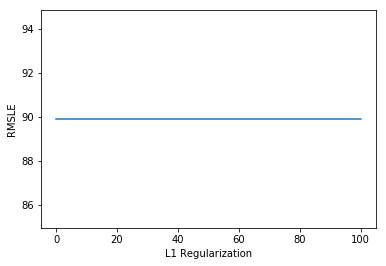

In [79]:
# 2.3.2.4) L1 Regularization

params_l1 = params = [0.0, 0.01, 0.1, 1.0, 10.0, 100.0]
metrics_l1 = [evaluate(trainingData_linear, testData_linear, 3, 0.01, param, 'l1', False) for param in params_l1]

print(params_l1)
print(metrics_l1)

# Plotting
plot(params_l1, metrics_l1)
plt.xlabel('L1 Regularization')
plt.ylabel('RMSLE')


[0.0, 0.01, 0.1, 1.0, 5.0, 10.0]
[148.44956842510899, 148.44956842510899, 148.44956842510899, 148.44956842510899, 148.44956842510899, 148.44956842510902]


Text(0,0.5,'RMSLE')

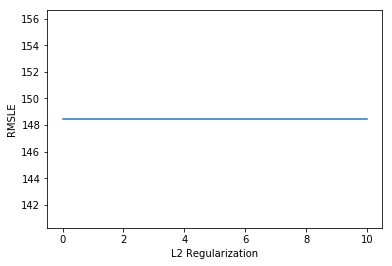

In [82]:
# 2.3.2.4) L2 Regularization

params_l2 = params = [0.0, 0.01, 0.1, 1.0, 5.0, 10.0]
metrics_l2 = [evaluate(trainingData_linear, testData_linear, 5, 0.01, param, 'l2', False) for param in params_l2]

print(params_l2)
print(metrics_l2)

# Plotting
plot(params_l2, metrics_l2)
plt.xlabel('L2 Regularization')
plt.ylabel('RMSLE')

In [17]:
# 2.3.3) Linear regression Log

rmsle_lr = np.sqrt(labelsAndPredictions_linear.map(lambda lp: squared_log_error(lp[0], lp[1])).mean())
mse_lr = labelsAndPredictions_linear.map(lambda lp: squared_error(lp[0], lp[1])).mean()
mae_lr = labelsAndPredictions_linear.map(lambda lp: abs_error(lp[0], lp[1])).mean()

print("LinearRegression Root Mean Squared Log Error: %2.4f" % rmsle_lr)
print("LinearRegression - Mean Squared Error: %2.4f" % mse_lr)
print("LinearRegression - Mean Absolute Error: %2.4f" % mae_lr)

LinearRegression Root Mean Squared Log Error: 148.3264
LinearRegression - Mean Squared Error: 6383601835483873906576159338040712415169926956325985980251688671301791433332872461139826715110840477293166869265317180303926664237529123111567360.0000
LinearRegression - Mean Absolute Error: 1070526403053328032556967594394421368909173562377140919628164074068508672.0000
